In [1]:
# Imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Exploring the Data

Loading one of the data files downloaded and checking the datasets available

In [2]:
file_path0 = 'data/MJD_Train_0.hdf5'

# Load the data file and checking the datasets 
with h5py.File(file_path0, 'r') as f:
    print('Datasets available in the file: ')
    for key in f.keys():
        print(key)

Datasets available in the file: 
detector
energy_label
id
psd_label_dcr
psd_label_high_avse
psd_label_low_avse
psd_label_lq
raw_waveform
run_number
tp0


Graph out one random waveform and check whether the labels are satisfied.

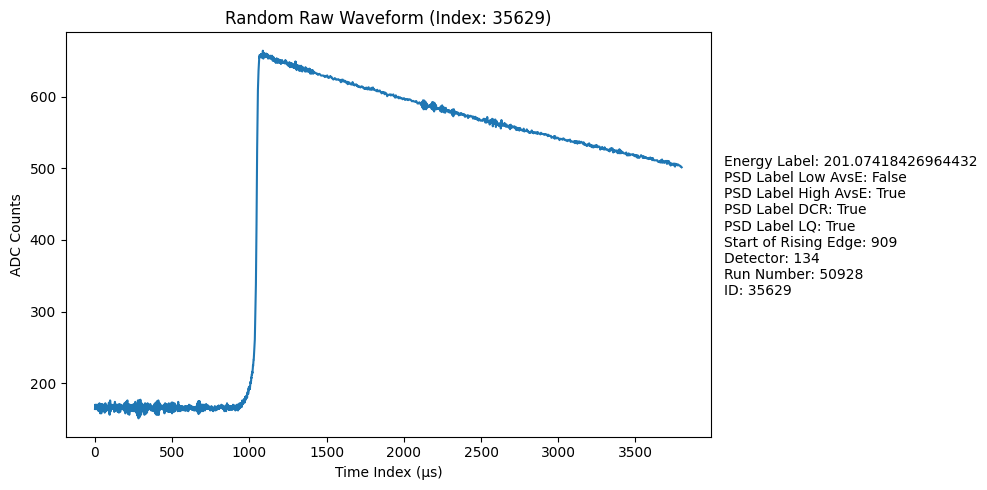

In [3]:
with h5py.File(file_path0, 'r') as f:
    # Load Waveform
    raw_waveform = np.array(f['raw_waveform'])
    
    # Load Labels
    energy_label = np.array(f['energy_label'])
    psd_label_low_avse = np.array(f['psd_label_low_avse'])
    psd_label_high_avse = np.array(f['psd_label_high_avse'])
    psd_label_dcr = np.array(f['psd_label_dcr'])
    psd_label_lq = np.array(f['psd_label_lq'])
    tp0 = np.array(f['tp0'])
    detector = np.array(f['detector'])
    run_number = np.array(f['run_number'])
    id = np.array(f['id'])

    # Get Index
    idx = np.random.choice(raw_waveform.shape[0])

    # Index Waveform
    idx_waveform = raw_waveform[idx]

    # Index Labels
    energy_value = energy_label[idx]
    psd_low_avse_value = psd_label_low_avse[idx]
    psd_high_avse_value = psd_label_high_avse[idx]
    psd_dcr_value = psd_label_dcr[idx]
    psd_lq_value = psd_label_lq[idx]
    tp0_value = tp0[idx]
    detector_value = detector[idx]
    run_number_value = run_number[idx]
    id_value = id[idx]
    
    # Plot Figure
    plt.figure(figsize=(10, 5))
    plt.plot(idx_waveform)
    plt.title(f"Random Raw Waveform (Index: {id_value})")
    plt.xlabel("Time Index (µs)")
    plt.ylabel("ADC Counts")

    # Display Labels
    label_text = (
        f"Energy Label: {energy_value}\n"
        f"PSD Label Low AvsE: {'True' if psd_low_avse_value else 'False'}\n"
        f"PSD Label High AvsE: {'True' if psd_high_avse_value else 'False'}\n"
        f"PSD Label DCR: {'True' if psd_dcr_value else 'False'}\n"
        f"PSD Label LQ: {'True' if psd_lq_value else 'False'}\n"
        f"Start of Rising Edge: {tp0_value}\n"
        f"Detector: {detector_value}\n"
        f"Run Number: {run_number_value}\n"
        f"ID: {id_value}\n"
    )
    plt.text(1.02, 0.5, label_text, transform=plt.gca().transAxes, verticalalignment='center')
    plt.tight_layout()
    plt.show()


As we can see from the graph above, most waveforms follow a similar shape where it rises at around the time index of 1000 and then slowly decreases after the peak. We are hoping to extract parameters from these waveform behaviors. 

## Parameter Extraction

### Time Drift 50% Threshold (tdrift50)

Creating a function for tdrift50, that is time indices between the start oft he rise and 50% of the rise.

We assume that all waveforms start to rise at time index tp0. Although this assumption should be correct for most waveforms in the data, we should figure out a better way to determine when the rise starts perhaps using the gradients of the slope. 

In [4]:
def get_tdrift50(waveform, start_idx):

    # Find the index of the peak value
    max_idx = np.argmax(waveform)

    # Calculate the middle y-value (50%) between start and max
    start_y = waveform[start_idx]
    max_y = waveform[max_idx]
    mid_y = (start_y + max_y) / 2

    # Find the x-value (index) where the waveform crosses the middle y-value
    mid_x_idx = start_idx + np.argmax(waveform[start_idx:max_idx] >= mid_y)
    
    tdrift50 = mid_x_idx - start_idx 

    return int(tdrift50)

In [5]:
idx = np.random.choice(raw_waveform.shape[0])
start_idx = tp0[idx]
idx_waveform = raw_waveform[idx]

get_tdrift50(idx_waveform, start_idx)

36

### Delayed Charge Recovery (dcr)

Another parameter we are planning on extracting is the Delayed Charge Recovery parameter which is measured by the area above the tail slope after the peak. This is calculated by finding the peak index, and using the np.trapezoid function to find this area. 

In [6]:
peak_idx = np.argmax(idx_waveform)
peak_val = int(idx_waveform[peak_idx])
data_after_peak = idx_waveform[peak_idx:]
time_indices = np.arange(peak_idx, len(idx_waveform))
area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 

print("Peak value:", peak_val)
print("Area above the curve after the peak:", area_above_tail_slope)

Peak value: 756
Area above the curve after the peak: 329980.0


The graph below provides a visualization on which area is being calculated.

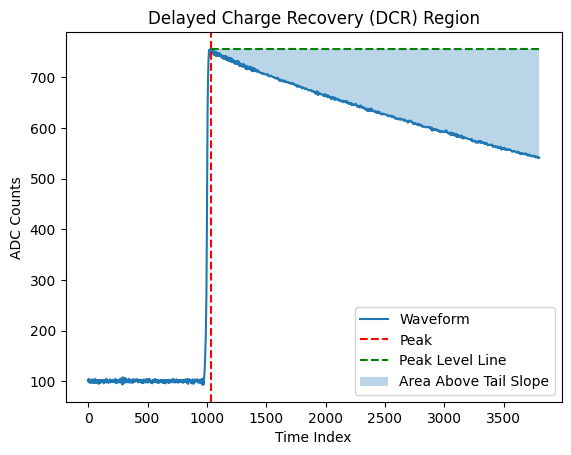

In [7]:
plt.plot(idx_waveform, label="Waveform")
plt.axvline(x=peak_idx, color='r', linestyle='--', label="Peak")
plt.hlines(peak_val, peak_idx, len(idx_waveform)-1, colors='g', linestyles='--', label="Peak Level Line")
plt.fill_between(time_indices, data_after_peak, peak_val, where=(data_after_peak < peak_val),
                 alpha=0.3, label="Area Above Tail Slope")
plt.xlabel("Time Index")
plt.ylabel("ADC Counts")
plt.legend()
plt.title("Delayed Charge Recovery (DCR) Region")
plt.show()

Now we create a general function to calculate the DCR for any waveform.

In [8]:
def find_dcr(waveform):

    # Find peak index value
    peak_idx = np.argmax(waveform)

    # Find peak value
    peak_val = int(waveform[peak_idx])

    # We are only looking at the data after the peak
    data_after_peak = waveform[peak_idx:]

    # Get all time indices between peak and end of the time series
    time_indices = np.arange(peak_idx, len(waveform))

    # Calculate DCR region
    area_above_tail_slope = np.trapezoid(peak_val - data_after_peak, x=time_indices) 
    
    return area_above_tail_slope

### Calculating the average for both parameters

Here the parameter functions are being applied to several different files.

In [9]:
files = [
    "MJD_Train_1.hdf5",
    "MJD_Train_2.hdf5",
    "MJD_Train_3.hdf5",
    "MJD_Train_4.hdf5"
]

Some waveforms in the data did not start its rise at index tp0 or the peak index is before the tp0 index, for these waveforms I chose to ignore and skip them for now but I may come back later to normalize my data just ot make sure every waveform rises at the same index.

In [ ]:
# Using my parameter functions on the first 4 training data files
for file_path in files:
    with h5py.File("data/" + file_path, 'r') as f:
        tdrift50_sum = 0
        dcr_sum = 0
        tdrift50_squared_sum = 0
        dcr_squared_sum = 0
        num_waveforms = 0

        raw_waveforms = np.array(f['raw_waveform'])
        tp0 = np.array(f['tp0'])

        for i in range(len(raw_waveforms)):
            # Check for empty waveforms and tp0 values
            if raw_waveforms[i].size == 0:
                continue
            if tp0[i] == None:
                continue

            max_idx = np.argmax(raw_waveforms[i])
            
            # Ignore waveforms where the peak is less than the rise index
            if max_idx < tp0[i]:
                continue

            # Calculate tdrift50 and DCR for the current waveform
            tdrift50 = get_tdrift50(raw_waveforms[i], tp0[i])
            dcr = find_dcr(raw_waveforms[i])

            # Accumulate sums for averages
            tdrift50_sum += tdrift50
            dcr_sum += dcr

            # Accumulate squared sums for MSE calculation
            tdrift50_squared_sum += tdrift50 ** 2
            dcr_squared_sum += dcr ** 2

            # Count waveforms
            num_waveforms += 1

        tdrift50_avg = tdrift50_sum / num_waveforms
        dcr_avg = dcr_sum / num_waveforms

        tdrift50_mse = (tdrift50_squared_sum / num_waveforms) - (tdrift50_avg ** 2)
        dcr_mse = (dcr_squared_sum / num_waveforms) - (dcr_avg ** 2)

        # Output the results
        print("Current File:", file_path)
        print("tdrift50 Average:", tdrift50_avg)
        print("DCR Average:", dcr_avg)
        print("Number of Valid Waveforms in File:", num_waveforms)
        print("\n")


Current File: MJD_Train_1.hdf5
tdrift50 Average: 72.63692591737826
DCR Average: 744351.2179326294
Number of Valid Waveforms in File: 64995


Current File: MJD_Train_2.hdf5
tdrift50 Average: 72.48478461538461
DCR Average: 751231.6965865385
Number of Valid Waveforms in File: 65000


Current File: MJD_Train_3.hdf5
tdrift50 Average: 72.3914060216311
DCR Average: 753450.9517021416
Number of Valid Waveforms in File: 64999


Current File: MJD_Train_4.hdf5
tdrift50 Average: 72.54586153846154
DCR Average: 748241.5083697116
Number of Valid Waveforms in File: 65000


